In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # for pandas warning

In [3]:
print(np.__version__) # 1.26.4 used
print(pd.__version__) # 2.2.1 used
print(matplotlib.__version__) # 3.8.4 used
print(sns.__version__) # 0.13.2 used


1.26.4
2.2.1
3.8.4
0.13.2


### Generating Voxel Data with Coordinates

First, I create a function that can generate a dataset where each voxel in a 3D grid (spatial coordinates and time) has a value drawn from a zero-inflated log-normal distribution.

This is to mimic the empirical distribution of a single country through time at the level of analysis of PRIO-grid years.

Each cell is given:

- A value (to emulate fatalities per 100,000 capita)
- A cell ID (similar to pg_id)
- A time ID (similar to year id)
- Row and column IDs (analogous to latitude and longitude)

In [4]:
def generate_data(num_rows=4, num_cols=4, num_time_periods=10, zero_inflation_prob=0.5, mean=5, sigma=1):
    """
    Generates a dataset of voxel data with the specified number of cells and time periods.
    Each cell is given a row and column number. Values are drawn from a zero-inflated log-normal distribution.
    
    Parameters:
    num_rows (int): Number of rows of unique grid cells
    num_cols (int): Number of columns of unique grid cells
    num_time_periods (int): Number of time periods each cell is observed
    zero_inflation_prob (float): Probability of a value being zero (zero-inflation)
    mean (float): Mean of the log-normal distribution
    sigma (float): Standard deviation of the log-normal distribution
    
    Returns:
    pd.DataFrame: A dataframe with columns ['cell_id', 'time_id', 'value', 'row', 'col']
    """
    np.random.seed(42)  # For reproducibility
    
    # Calculate total number of cells
    num_cells = num_rows * num_cols
    
    # Generate cell_ids, row_ids, and col_ids
    cell_ids = np.repeat(np.arange(num_cells), num_time_periods)
    row_ids = np.repeat(np.arange(num_rows), num_cols * num_time_periods)
    col_ids = np.tile(np.repeat(np.arange(num_cols), num_time_periods), num_rows)
    time_ids = np.tile(np.arange(num_time_periods), num_cells)
    
    # Generate log-normal values
    log_normal_values = np.random.lognormal(mean, sigma, num_cells * num_time_periods)
    
    # Apply zero inflation
    zero_mask = np.random.rand(num_cells * num_time_periods) < zero_inflation_prob
    values = np.where(zero_mask, 0, log_normal_values)
    
    # Clip values to be between 0 and 1000
    values = np.clip(values, 0, 1000)
    
    # Create the dataframe
    data = pd.DataFrame({
        'cell_id': cell_ids,
        'time_id': time_ids,
        'value': values,
        'row': row_ids,
        'col': col_ids
    })
    
    return data

### Visualizing Voxel Data Distributions

This function creates three side-by-side plots to provide a comprehensive view of the voxel data distribution. These visualizations help us understand the distribution of values in different contexts.

1. **Overall Distribution of Values**: A histogram with a KDE plot showing the distribution of all voxel values. This plot helps identify the general distribution pattern and the frequency of different values.

2. **Value Distribution for One Time Period**: A 2D heatmap displaying the distribution of values for a specific time period (e.g., time_id = 0). This plot provides a snapshot of the spatial distribution of values at a particular time.

3. **Average Value Distribution Across All Time Periods**: A 2D heatmap showing the average values for each cell across all time periods. This plot highlights the overall spatial distribution trends over the entire observation period.

These plots are both here to check that the generated data effectivly mimics to empirical data but also to show the nature of this kind of zero-inflated long-tailed distributions.

In [5]:
def plot_data_distributions(data):
    """
    Plots the distribution of values in the dataset, the distribution across one time period as a 2D heatmap,
    and the average distribution across time as a 2D heatmap, all side by side.
    
    Parameters:
    data (pd.DataFrame): The voxel data with columns ['cell_id', 'time_id', 'value', 'row', 'col']
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot the overall distribution of values
    sns.histplot(data['value'], bins=50, kde=True, ax=axes[0])
    axes[0].set_title('Overall Distribution of Values')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)
    
    # Plot the distribution of values for one time period (e.g., time_id = 0)
    time_period = 0
    time_slice = data[data['time_id'] == time_period]
    pivot_time_slice = time_slice.pivot(index='row', columns='col', values='value')
    
    sns.heatmap(pivot_time_slice, annot=True, fmt=".1f", cmap='rainbow', ax=axes[1], vmin=data['value'].min(), vmax=data['value'].max())
    axes[1].set_title(f'Value Distribution at Time Period {time_period}')
    axes[1].set_xlabel('Column')
    axes[1].set_ylabel('Row')
    
    # Plot the average distribution across all time periods
    avg_values = data.groupby(['row', 'col'])['value'].mean().reset_index()
    pivot_avg_values = avg_values.pivot(index='row', columns='col', values='value')
    
    sns.heatmap(pivot_avg_values, annot=True, fmt=".1f", cmap='rainbow', ax=axes[2], vmin=data['value'].min(), vmax=data['value'].max())
    axes[2].set_title('Average Value Distribution Across All Time Periods')
    axes[2].set_xlabel('Column')
    axes[2].set_ylabel('Row')
    
    plt.tight_layout()
    plt.show()

In [21]:
# Generate the dataset
df = generate_data(num_cols= 8, num_rows= 8, num_time_periods= 100, zero_inflation_prob=0.95, mean=4, sigma=5)
df.sample(5)

,cell_id,time_id,value,row,col
3284,32,84,0.000000,4,0
5143,51,43,7.118517,6,3
2067,20,67,0.000000,2,4
5762,57,62,0.000000,7,1
6226,62,26,0.000000,7,6


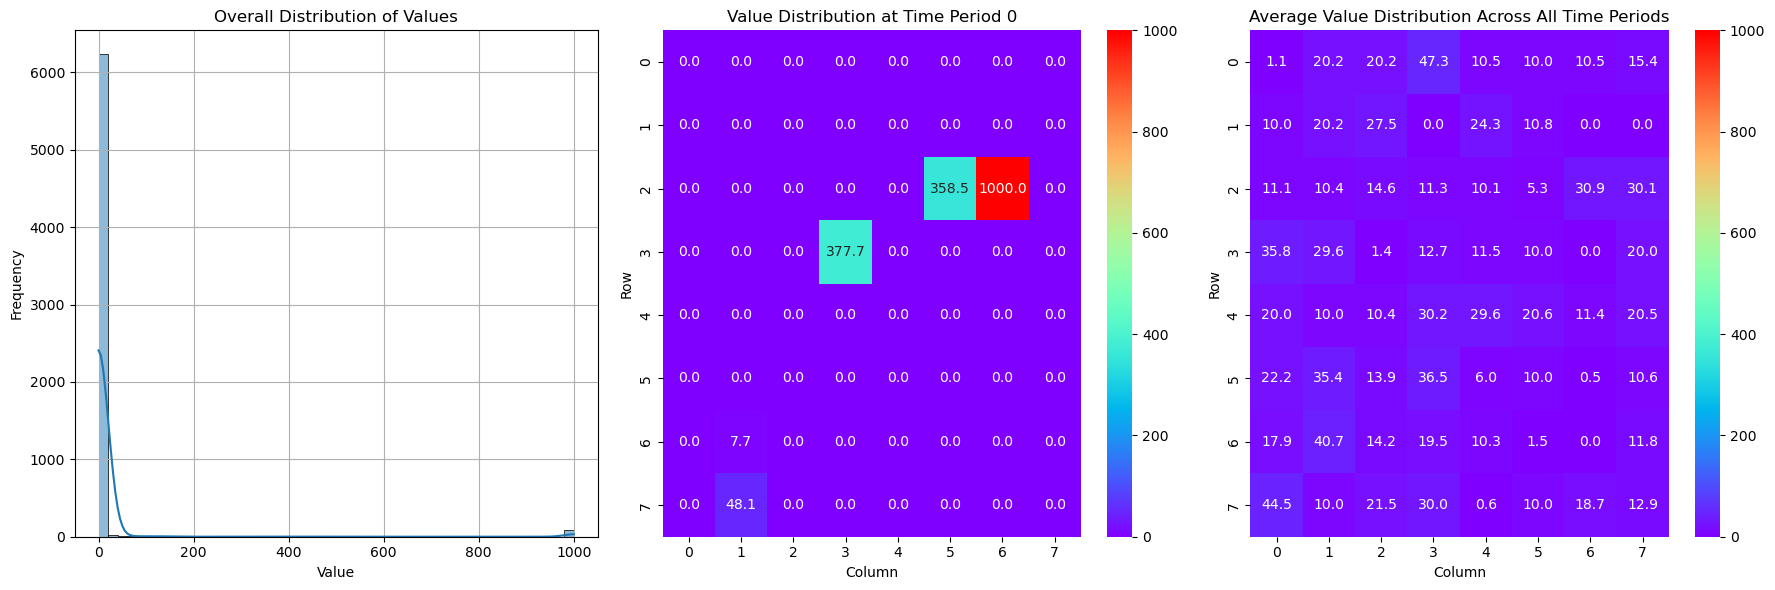

In [22]:
# Plot the distributions side by side using the generated dataset
plot_data_distributions(df)

### Calculating the Cumulative Distribution of Voxel Values

This function calculates the cumulative distribution of values across all voxels. This is useful for understanding how values are accumulated in the dataset and helps in determining the proportion of voxels with values greater than or equal to a specific value.

1. **Calculate Value Frequencies**:
    - The function starts by counting the occurrences of each unique value in the dataset and sorts these counts in descending order. This step helps in understanding the distribution of individual values.

2. **Compute Cumulative Distribution**:
    - The function then computes the cumulative sum of these sorted counts. The cumulative sum provides the total count of voxels with values greater than or equal to each unique value. Mathematically, if $ f(x) $ is the frequency of value $ x $, the cumulative distribution $ F(x) $ is given by:
    
    $$
    F(x) = \sum_{v \geq x} f(v)
    $$

    where $ v $ represents each unique value greater than or equal to $ x $.

3. **Return the Cumulative Distribution**:
    - Finally, the function returns the cumulative distribution as a pandas Series. This series can be used for further analysis, such as calculating probabilities or identifying trends in the data.

The cumulative distribution provides insights into how values are distributed and helps identify the proportion of voxels with high values. This is be particularly useful for understanding the spatial and temporal distribution of significant events or measurements in the dataset.

In [7]:
def calculate_cumulative_distribution(data):
    """
    Calculate the cumulative distribution of values across all voxels.
    
    Parameters:
    data (pd.DataFrame): The voxel data with columns ['cell_id', 'time_id', 'value', 'row', 'col']
    
    Returns:
    pd.Series: Cumulative counts of voxels with value >= each unique value
    """
    # Calculate the frequency of each value
    value_counts = data['value'].value_counts().sort_index(ascending=False)
    
    # Calculate the cumulative distribution
    cumulative_distribution = value_counts.cumsum()
    
    return cumulative_distribution


### Calculating Probabilities $ p_i $ and $ P_i $ 

This function calculates two important probabilities for each unique value in the dataset:
- $ p_i $: The probability of drawing a voxel with a value greater than or equal to $ i $.
- $ P_i $: The probability of seeing at least one voxel with a value greater than or equal to $ i $ in a random time period.

1. **Calculate Total Number of Voxels**:
    - Determines the total number of voxels in the dataset to use in probability calculations.

2. **Calculate Number of Unique Grid Cells per Time Period**:
    - Finds out how many unique grid cells are observed in each time period.

3. **Calculate $ p_i $**:
    - $ p_i $ represents the probability of drawing a voxel with a value greater than or equal to $ i $. It is calculated by dividing the cumulative count of values by the total number of voxels.

    $$
    p_i = \frac{T_i}{N \times M}
    $$

    where $ T_i $ is the cumulative count of values, $ N $ is the number of grid cells, and $ M $ is the number of time periods.

4. **Calculate $P_i$**:
    - $ P_i $ is the probability of seeing at least one voxel with a value greater than or equal to $ i $ in any given time period. If we denote "num cells per time period" h, them the formula it:

    $$
    P_i = 1 - (1 - p_i)^{h}
    $$

    This is based on the probability of at least one success in a series of independent trials.

5. **Combine into a DataFrame**:
    - Creates a pandas DataFrame containing the values, $ p_i $, and $ P_i $ for easy interpretation and analysis.
 

These probabilities are crucial for understanding the distribution of values in the dataset and for making informed decisions based on the likelihood of different value occurrences.

In [8]:
def calculate_probabilities(cumulative_distribution, data):
    """
    Calculate the probabilities p_i and P_i for each value i.
    
    Parameters:
    cumulative_distribution (pd.Series): Cumulative counts of voxels with value >= each unique value
    data (pd.DataFrame): The voxel data with columns ['cell_id', 'time_id', 'value', 'row', 'col']
    
    Returns:
    pd.DataFrame: DataFrame containing values, p_i, and P_i
    """
    # Calculate total number of voxels
    total_voxels = len(data)
    
    # Number of unique grid cells observed at each time period
    num_cells_per_time_period = data['cell_id'].nunique()
    
    # Calculate p_i for each value
    p_i = cumulative_distribution / total_voxels
    
    # Calculate P_i for each value
    P_i = 1 - (1 - p_i) ** num_cells_per_time_period
    
    # Combine into a DataFrame
    probabilities = pd.DataFrame({
        'value': cumulative_distribution.index,
        'p_i': p_i.values,
        'P_i': P_i.values
    })
    
    return probabilities


### Calculating Expected Number of Time Periods to survey ($ E_i $)

This function calculates the expected number of time periods to survay to find at least one voxel with a value greater than or equal to $i$. This is likely the most reasnoble way to define **return periods** in our use case 

#### Steps:
1. **Calculate $E_i$**:
    - $E_i$ represents the expected number of time periods to check to find at least one voxel with a value greater than or equal to $i$. It is calculated using the formula:
    
    $$
    E_i = \frac{1}{P_i}
    $$

    where $P_i$ is the probability of seeing one or more voxels with value $\geq i$ in a random time period.

2. **Return $E_i$**:
    - The function returns $E_i$ as a pandas Series, providing a measure of how frequently one might need to check time periods to find significant values.

Understanding the expected number of time periods to check ($E_i$) is crucial for planning and decision-making. It helps in estimating the frequency of observations needed to detect significant events or values in the dataset. As already noted, this is likely the best definition of **return periods** for our use case (fatalities per 100,000 in one PRIO-grid year).

In [9]:
def calculate_expected_time_periods(P_i):
    """
    Calculate the expected number of time periods to check (E_i) for each value i.
    
    Parameters:
    P_i (pd.Series): Probability of seeing one or more voxels with value >= i in a random time period
    
    Returns:
    pd.Series: Expected number of time periods to check for each value
    """
    # Calculate E_i for each value
    E_i = 1 / P_i
    
    return E_i


### Calculating Expected Number of Voxels to Draw ($E_{i}^{\text{voxels}}$)

This function is analogous to the one above but calculates the expected number of voxels to draw to see at least one voxel with a value greater than or equal to $i$. This helps illustrate why using the number of individual voxels surveyed provides a misleading "return period."

#### Steps:
1. **Calculate $E_{i}^{\text{voxels}}$**:
    - $E_{i}^{\text{voxels}}$ represents the expected number of voxels to draw to see at least one voxel with a value greater than or equal to $i$. It is calculated using the formula:
    
    $$
    E_{i}^{\text{voxels}} = \frac{1}{p_i}
    $$
    
    where $p_i$ is the probability of drawing a voxel with value $\geq i$.
    
2. **Return $E_{i}^{\text{voxels}}$**:
    - The function returns $E_{i}^{\text{voxels}}$ as a pandas Series, providing a measure of how many voxels one might need to check to find significant values.

Understanding $E_{i}^{\text{voxels}}$ is crucial for illustrating why having "return periods" referring to individual voxels is misleading for our use case. The "return period" calculated this way would reflect the number of individual voxels surveyed, not the number of time periods.

To give an analogy, this would be like asking how many people you would need to meet on average to find one who is over 2.20 meters tall. Instead, we should be asking how often a person who will grow to be over 2.20 meters tall is born. At least this would better reflect what is usually meant by return periods. 

Back to our use case: Having return periods based on voxels would mean that in a country with 100 cells, a return period of 100 would imply that we expect to see this event once a year on average. And for a country with 200 cells, we would expect to see such an event twice a year. This would be a confusing definition of return periods, even if it is not as such mathematically wrong.

In [10]:
# Assuming probabilities DataFrame has been calculated already
def calculate_expected_voxels(p_i):
    """
    Calculate the expected number of voxels to draw (E_i^voxels) to see a value >= i.
    
    Parameters:
    p_i (pd.Series): Probability of drawing a voxel with value >= i
    
    Returns:
    pd.Series: Expected number of voxels to draw for each value
    """
    # Calculate E_i^voxels for each value
    E_i_voxels = 1 / p_i
    
    return E_i_voxels



### Now, generating the data along with $E_i$ and $E_i^{voxel}$

In [11]:
# Calculate the cumulative distribution
cumulative_distribution = calculate_cumulative_distribution(df)

# Calculate the probabilities p_i and P_i using the updated function
probabilities = calculate_probabilities(cumulative_distribution, df)

# Calculate the expected number of time periods to check E_i
probabilities['E_i'] = calculate_expected_time_periods(probabilities['P_i'])

# Calculate E_i^voxels
probabilities['E_i_voxels'] = calculate_expected_voxels(probabilities['p_i'])

probabilities.head(10)


,value,p_i,P_i,E_i,E_i_voxels
0,1000.000000,0.013125,0.570684,1.752284,76.190476
1,949.463446,0.013281,0.575012,1.739093,75.294118
2,889.533860,0.013437,0.579298,1.726227,74.418605
3,852.706946,0.013594,0.583541,1.713675,73.563218
4,801.961029,0.013750,0.587742,1.701427,72.727273
5,776.759264,0.013906,0.591901,1.689471,71.910112
6,745.591185,0.014063,0.596019,1.677798,71.111111
7,641.891868,0.014219,0.600096,1.666399,70.329670
8,604.089822,0.014375,0.604133,1.655265,69.565217
9,578.252922,0.014531,0.608129,1.644387,68.817204


### What we expect from return periods

The next function compares the empirical frequencies of randomly chosen $E_i$ and $E_{i}^{\text{voxels}}$ values with their expected frequencies in terms of both time periods and individual voxels. This helps to illustrate why using the number of individual voxels provides a misleading "return period."

1. **Number of Time Periods**: The number of time periods in the dataset is calculated.

2. **Random Sampling of Non-Zero $E_i$ Values**: Three non-zero $E_i$ values are randomly sampled for comparison.

3. **Empirical and Expected Frequencies for Time Periods**:
    - For each sampled $E_i$ value:
      - The empirical frequency of time periods where at least one voxel has a value greater than or equal to the minimum value corresponding to that $E_i$ is calculated.
      - The expected frequency, assuming $E_i$ represents the average number of time periods between such events, is calculated as:
      
      $$
      \text{Expected Frequency} = \frac{\text{Number of Time Periods}}{E_i}
      $$

4. **Random Sampling of Non-Zero $E_{i}^{\text{voxels}}$ Values**:
    - Three non-zero $E_{i}^{\text{voxels}}$ values are randomly sampled for comparison.

5. **Empirical and Expected Frequencies for Voxels**:
    - For each sampled $E_{i}^{\text{voxels}}$ value:
      - The empirical frequency of individual voxels with values greater than or equal to the minimum value corresponding to that $E_{i}^{\text{voxels}}$ is calculated.
      - The expected frequency, assuming $E_{i}^{\text{voxels}}$ represents the average number of time periods between such events (even though this is misleading), is calculated as:
      $$
      \text{Expected Frequency} = \frac{\text{Number of Time Periods}}{E_{i}^{\text{voxels}}}
      $$

We calculate the "Expected Frenquency" for $E_{i}^{\text{voxels}}$ in this "misleading" manner because this is how people will interpret our use of the term "return periods".

Thus, by comparing these empirical frequencies with the expected frequencies, we can see that using the number of individual voxels as a "return period" leads to much higher observed frequencies than expected. This highlights why it is misleading to use \( E_{i}^{\text{voxels}} \) for defining return periods in terms of time.

In [12]:
def compare_empirical_vs_expected(data, probabilities, num_samples=3):
    """
    Compare empirical frequencies of randomly chosen E_i values with their expected frequencies
    in terms of both time periods and individual voxels.
    
    Parameters:
    data (pd.DataFrame): The voxel data with columns ['cell_id', 'time_id', 'value', 'row', 'col']
    probabilities (pd.DataFrame): DataFrame containing values, p_i, P_i, E_i, and E_i_voxels
    num_samples (int): Number of random E_i values to sample for comparison
    
    Returns:
    pd.DataFrame, pd.DataFrame: DataFrames containing the comparison of empirical vs expected frequencies
    """
    # Number of time periods in the dataset
    num_time_periods = data['time_id'].nunique()
    
    # Randomly sample three non-zero E_i values
    non_zero_E_i = probabilities[probabilities['E_i'] > 0]['E_i'].unique()
    sampled_E_i = np.random.choice(non_zero_E_i, size=num_samples, replace=False)
    
    time_period_results = []
    voxel_results = []

    for E_i_val in sampled_E_i:
        min_value = probabilities[probabilities['E_i'] == E_i_val]['value'].min()
        
        # Empirical frequency in time periods
        empirical_freq_time = data.groupby('time_id').apply(
            lambda x: (x['value'] >= min_value).any()).sum()
        expected_freq_time = num_time_periods / E_i_val

        time_period_results.append({
            'E_i_value': E_i_val,
            'empirical_freq_time': empirical_freq_time,
            'expected_freq_time': expected_freq_time
        })
    
    # Randomly sample three non-zero E_i_voxels values
    non_zero_E_i_voxels = probabilities[probabilities['E_i_voxels'] > 0]['E_i_voxels'].unique()
    sampled_E_i_voxels = np.random.choice(non_zero_E_i_voxels, size=num_samples, replace=False)

    for E_i_voxels_val in sampled_E_i_voxels:
        min_value = probabilities[probabilities['E_i_voxels'] == E_i_voxels_val]['value'].min()

        # Empirical frequency in voxels
        empirical_freq_voxels = (data['value'] >= min_value).sum()

        # Expected frequency in voxels (using the common understanding of return periods)
        expected_freq_voxels = num_time_periods / E_i_voxels_val

        voxel_results.append({
            'E_i_voxels_value': E_i_voxels_val,
            'empirical_freq_voxels': empirical_freq_voxels,
            'expected_freq_voxels': expected_freq_voxels
        })
    
    time_period_df = pd.DataFrame(time_period_results)
    voxel_df = pd.DataFrame(voxel_results)
    
    return time_period_df, voxel_df

In [13]:
# Assuming voxel_data_with_coords and probabilities DataFrames have been calculated already
time_period_df, voxel_df = compare_empirical_vs_expected(df, probabilities, num_samples= 30)

In [14]:
time_period_df.head(10) 

,E_i_value,empirical_freq_time,expected_freq_time
0,1.288187,79,77.628469
1,1.284417,79,77.856330
2,1.116584,91,89.558870
3,1.117941,91,89.450153
4,1.040731,98,96.086270
5,1.507114,69,66.351992
6,1.135649,90,88.055358
7,1.623368,62,61.600331
8,1.196799,86,83.556203
9,1.049086,98,95.321062


In [15]:
voxel_df.head(10) 

,E_i_voxels_value,empirical_freq_voxels,expected_freq_voxels
0,28.193833,227,3.546875
1,29.090909,220,3.437500
2,29.906542,214,3.343750
3,41.830065,153,2.390625
4,32.989691,194,3.031250
5,30.188679,212,3.312500
6,62.745098,102,1.593750
7,21.621622,296,4.625000
8,24.806202,258,4.031250
9,35.754190,179,2.796875


We can plot the difference:

In [16]:
def plot_correlation(time_period_df, voxel_df):
    """
    Plot the correlation between observed and expected frequencies for both time periods and voxels.
    
    Parameters:
    time_period_df (pd.DataFrame): DataFrame containing the comparison of empirical vs expected frequencies for time periods
    voxel_df (pd.DataFrame): DataFrame containing the comparison of empirical vs expected frequencies for voxels
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot for time periods
    sns.scatterplot(x='expected_freq_time', y='empirical_freq_time', data=time_period_df, ax=axes[0])
    axes[0].set_title('Correlation between Observed and Expected Frequencies (Time Periods)')
    axes[0].set_xlabel('Expected Frequency')
    axes[0].set_ylabel('Empirical Frequency')
    axes[0].plot([time_period_df['expected_freq_time'].min(), time_period_df['expected_freq_time'].max()], 
                 [time_period_df['expected_freq_time'].min(), time_period_df['expected_freq_time'].max()], 
                 ls="--", c=".3")

    # Plot for voxels
    sns.scatterplot(x='expected_freq_voxels', y='empirical_freq_voxels', data=voxel_df, ax=axes[1])
    axes[1].set_title('Correlation between Observed and Expected Frequencies (Voxels)')
    axes[1].set_xlabel('Expected Frequency')
    axes[1].set_ylabel('Empirical Frequency')
    axes[1].plot([voxel_df['expected_freq_voxels'].min(), voxel_df['expected_freq_voxels'].max()], 
                 [voxel_df['expected_freq_voxels'].min(), voxel_df['expected_freq_voxels'].max()], 
                 ls="--", c=".3")

    plt.tight_layout()
    plt.show()


In [17]:
def plot_correlation(time_period_df, voxel_df):
    """
    Plot the correlation between observed and expected frequencies for both time periods and voxels.
    
    Parameters:
    time_period_df (pd.DataFrame): DataFrame containing the comparison of empirical vs expected frequencies for time periods
    voxel_df (pd.DataFrame): DataFrame containing the comparison of empirical vs expected frequencies for voxels
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot for time periods
    sns.scatterplot(x='expected_freq_time', y='empirical_freq_time', data=time_period_df, ax=axes[0], label='Empirically Observed')
    axes[0].set_title('Correlation between Observed and Expected Frequencies (Time Periods)')
    axes[0].set_xlabel('Expected Frequency')
    axes[0].set_ylabel('Empirical Frequency')
    axes[0].plot([time_period_df['expected_freq_time'].min(), time_period_df['expected_freq_time'].max()], 
                 [time_period_df['expected_freq_time'].min(), time_period_df['expected_freq_time'].max()], 
                 ls="--", c=".3", label='If Expected = Empirical')
    axes[0].legend()

    # Plot for voxels
    sns.scatterplot(x='expected_freq_voxels', y='empirical_freq_voxels', data=voxel_df, ax=axes[1], label='Empirically Observed')
    axes[1].set_title('Correlation between Observed and Expected Frequencies (Voxels)')
    axes[1].set_xlabel('Expected Frequency')
    axes[1].set_ylabel('Empirical Frequency')
    axes[1].plot([voxel_df['expected_freq_voxels'].min(), voxel_df['expected_freq_voxels'].max()], 
                 [voxel_df['expected_freq_voxels'].min(), voxel_df['expected_freq_voxels'].max()], 
                 ls="--", c=".3", label='If Expected = Empirical')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

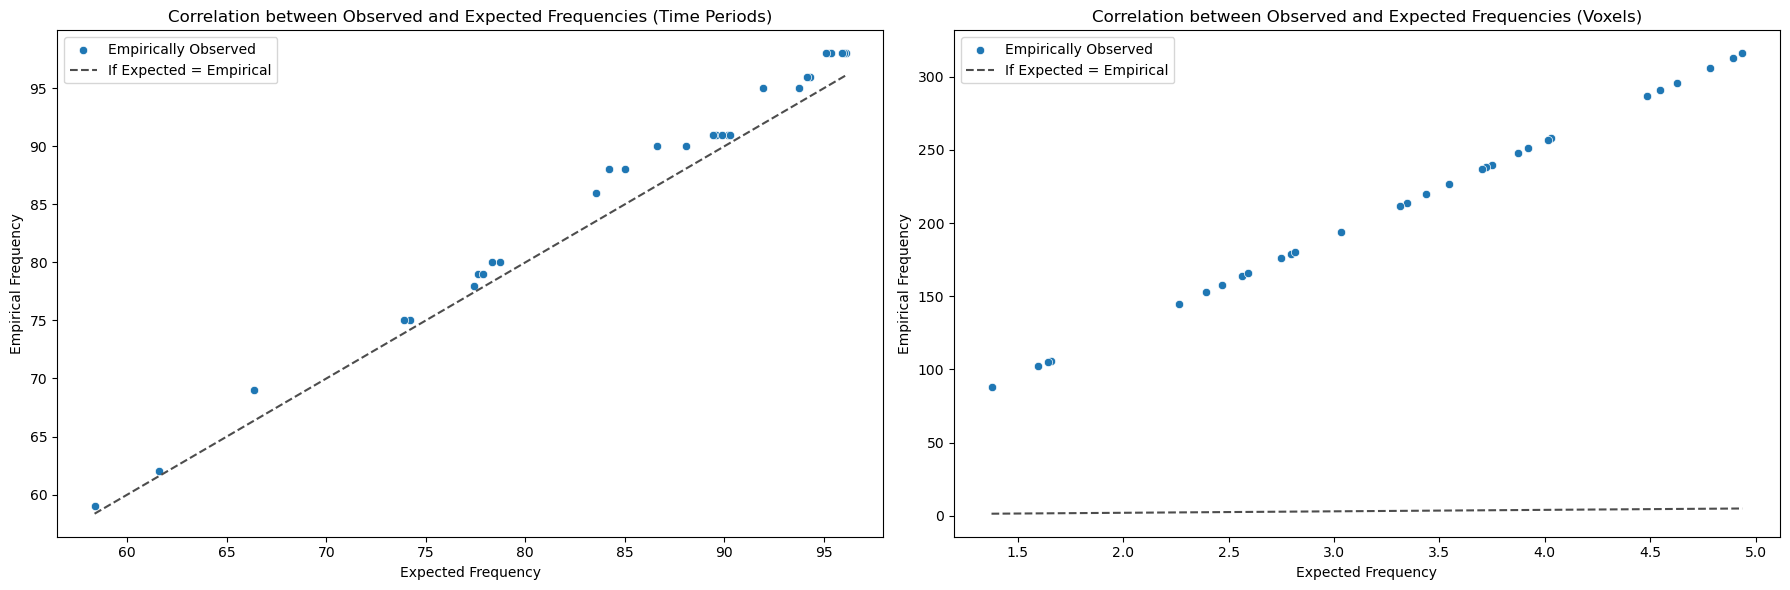

In [18]:
# Plot the correlation
plot_correlation(time_period_df, voxel_df)

### conclusion of comparsion:
Hofully it is clear that using $E_{i}$ as the basis for return periods conforms with the common understanding of return period while using $E_{i}^{\text{voxels}}$ will tend to mislead people. 

### Plotting more results

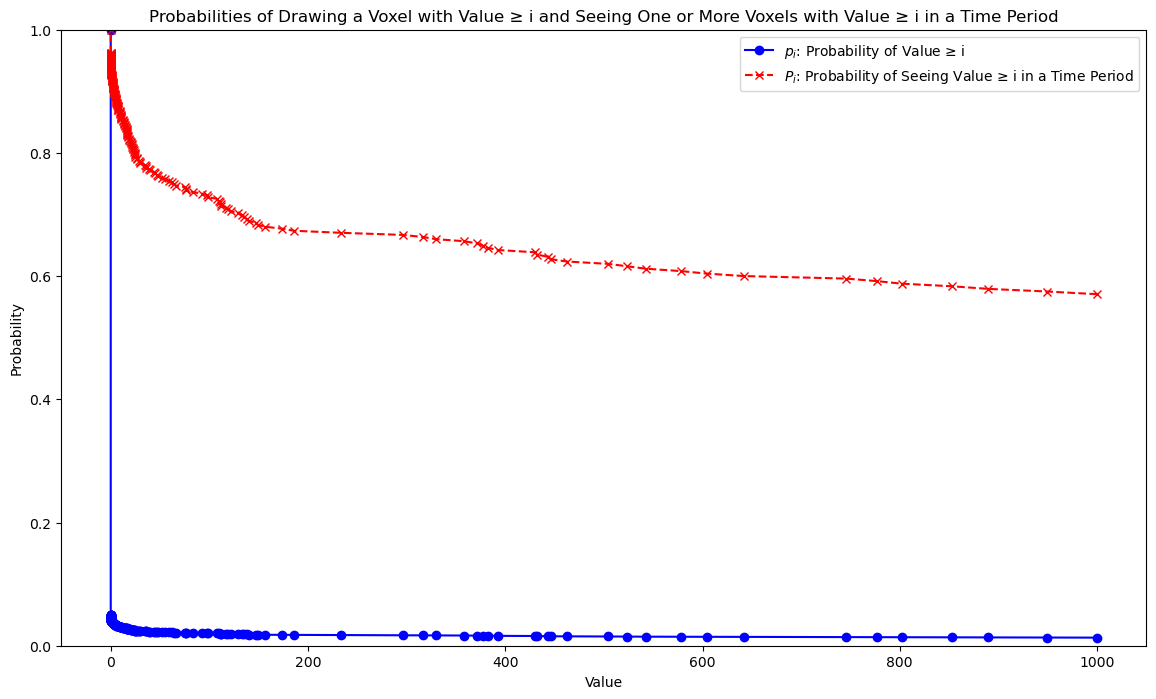

In [19]:

def plot_probabilities_single_axis(probabilities):
    """
    Plots the probabilities p_i and P_i with a shared y-axis, displaying probabilities in the range 0-1.
    
    Parameters:
    probabilities (pd.DataFrame): DataFrame containing values, p_i, P_i, and E_i
    """
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot p_i with clear labels and markers
    ax1.plot(probabilities['value'], probabilities['p_i'], color='blue', marker='o', label='$p_i$: Probability of Value ≥ i')
    
    # Plot P_i with clear labels and markers
    ax1.plot(probabilities['value'], probabilities['P_i'], color='red', marker='x', linestyle='--', label='$P_i$: Probability of Seeing Value ≥ i in a Time Period')
    
    # Set axis labels and title
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Probability')
    ax1.set_ylim(0, 1)  # Set y-axis to show probabilities in the range 0-1
    ax1.set_title('Probabilities of Drawing a Voxel with Value ≥ i and Seeing One or More Voxels with Value ≥ i in a Time Period')
    
    # Add legend
    ax1.legend()
    
    plt.show()

# Plot the probabilities using the generated probabilities DataFrame with a single y-axis
plot_probabilities_single_axis(probabilities)


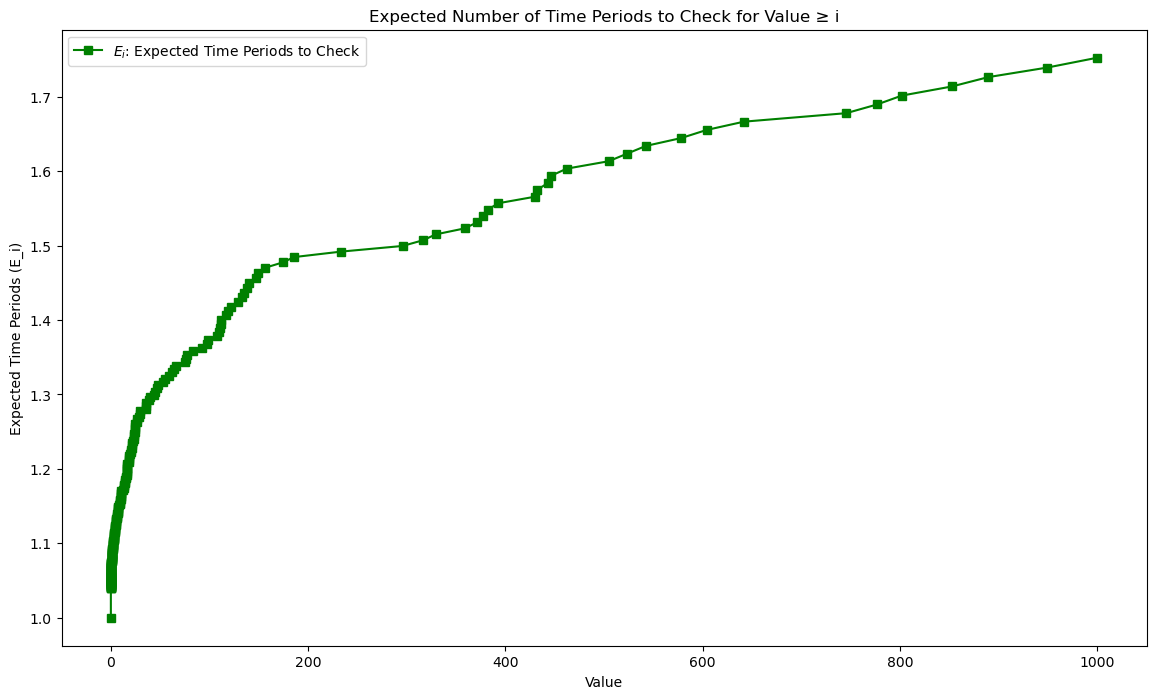

In [20]:
def plot_return_periods_normal_notation(probabilities, log_scale=True):
    """
    Plots the expected number of time periods to check (E_i) with clear labels and markers,
    and with time in normal notation instead of scientific notation. An option to not have the y-axis logarithmically transformed is provided.
    
    Parameters:
    probabilities (pd.DataFrame): DataFrame containing values, p_i, P_i, and E_i
    log_scale (bool): If True, use logarithmic scale for y-axis. If False, use linear scale.
    """
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot E_i with clear labels and markers
    ax1.plot(probabilities['value'], probabilities['E_i'], color='green', marker='s', label='$E_i$: Expected Time Periods to Check')
    
    # Set axis labels and title
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Expected Time Periods (E_i)')
    if log_scale:
        ax1.set_yscale('log')  # Use logarithmic scale for better visualization
    ax1.set_title('Expected Number of Time Periods to Check for Value ≥ i')
    
    # Ensure the y-axis uses normal notation
    ax1.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax1.get_yaxis().set_minor_formatter(plt.ScalarFormatter())
    
    # Add legend
    ax1.legend()
    
    plt.show()

plot_return_periods_normal_notation(probabilities, log_scale=False)
